In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2,dlib,shutil
from glob import glob
from PIL import Image
import os,sys,gdown
from zipfile import ZipFile
from tensorflow.keras.layers import Dense,Input,Flatten,Lambda
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19

import warnings
warnings.filterwarnings('ignore')
 
directory = '/content/drive/My Drive/Grocery-data/'
plt.rcParams['figure.figsize'] = (10,10)

#! pip install rarfile
#import rarfile
#with rarfile.RarFile('/content/drive/My Drive/Grocery-data.rar', 'r') as zip:
#  zip.extractall(path = "/content/drive/My Drive/")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
paths = glob(directory+'*')
img_size = 256
anchor_class = 0
classes = [name.split('/')[-1] for name in paths]
print(*classes)

SPICES SUGAR TEA TOMATO_SAUCE VINEGAR WATER TV Soyghurt Yoghurt Tomato Zucchini Apple Asparagus Aubergine Avocado Banana BEANS Books Brown-Cap-Mushroom Cabbage CAKE CANDY Carrots CEREAL CHIPS CHOCOLATE COFFEE CORN Cucumber FISH FLOUR Garlic Ginger HONEY JAM JUICE Kiwi Leek Lemon Lime Mango Melon MILK Mobiles Mobiles nd Laptops Namkeen Nectarine NUTS Oat-Milk Oatghurt OIL Onion Orange Papaya Passion-Fruit PASTA Peach Pear Pepper Pineapple Plum Pomegranate Potato Red-Beet Red-Grapefruit RICE Roti and Bread Satsumas SODA Sour-Cream Sour-Milk Soy-Milk


In [ ]:
def make_input_array(paths,img_size = 256):
  array = np.zeros((len(paths) * 20,img_size,img_size,3),dtype = np.uint8)
  labels = np.zeros((len(paths) * 20))
  img_count = 0
  label_count = 0

  for path in paths:
    random_img_paths = np.random.choice(glob(path + "/*"),size = 20)
    for img_path in random_img_paths:
      img = cv2.resize(np.asarray(Image.open(img_path),np.uint8),(256,256))
      array[img_count] = img[:,:,:3]
      labels[img_count] = label_count
      img_count+=1
    label_count+=1

  return array,labels

In [ ]:
img_array,img_labels = make_input_array(paths)

In [ ]:
def batch_images(img_array = img_array ,img_labels = img_labels,img_size = img_size,dataset_size = 32):

  global anchor_class
  batch_count = 0
  batch_size = dataset_size
  input_array = [np.zeros((batch_size,img_size,img_size,3),np.uint8),np.zeros((batch_size,img_size,img_size,3),np.uint8)]
  labels_array = np.zeros((batch_size))

  while (batch_count < batch_size):

    anchor_class = (anchor_class % len(paths))
    idxs = [np.where(img_labels == i)[0] for i in range(len(paths))]

    anchor_idx = np.random.choice(20)
    pos_idx = np.random.choice([i for i in range(20) if i!= anchor_idx])
    neg_idx = np.random.choice(20)
    neg_class = np.random.choice([i for i in range(len(paths)) if i!= anchor_class])

    #anchor = np.expand_dims(img_array[idxs[anchor_class][anchor_idx]],axis = 0)
    #positive = np.expand_dims(img_array[idxs[anchor_class][pos_idx]],axis = 0)
    #negative = np.expand_dims(img_array[idxs[neg_class][neg_idx]],axis = 0)

    input_array[0][batch_count] = img_array[idxs[anchor_class][anchor_idx]]
    input_array[1][batch_count] = img_array[idxs[anchor_class][pos_idx]]
    labels_array[batch_count] = 1

    input_array[0][batch_count+1] = img_array[idxs[anchor_class][anchor_idx]]
    input_array[1][batch_count+1] = img_array[idxs[neg_class][neg_idx]]
    labels_array[batch_count+1] = 0

    batch_count +=2
    anchor_class+=1

  return input_array,labels_array

In [ ]:
# Initializes the embedding model and pre trained weights
ptm = ResNet50(input_shape = (img_size,img_size,3), include_top=False,weights="imagenet")
x = Flatten()(ptm.output)
x = Dense(128)(x)
emb_model = Model(ptm.input,x)

for layer in emb_model.layers[:-5]:
  layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
class Euclidean_Distance(tf.keras.layers.Layer):
    def __init__(self):
      super(Euclidean_Distance, self).__init__()

    def call(self, outputs):
      emb_A,emb_B = outputs
      return tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(emb_A,emb_B),2),axis = 1))

In [ ]:
img_A = Input(shape = (img_size,img_size,3))
img_B = Input(shape = (img_size,img_size,3))
emb_A = emb_model(img_A)
emb_B = emb_model(img_B)
distance = Euclidean_Distance()([emb_A,emb_B])
model = Model(inputs = [img_A,img_B], outputs = distance)

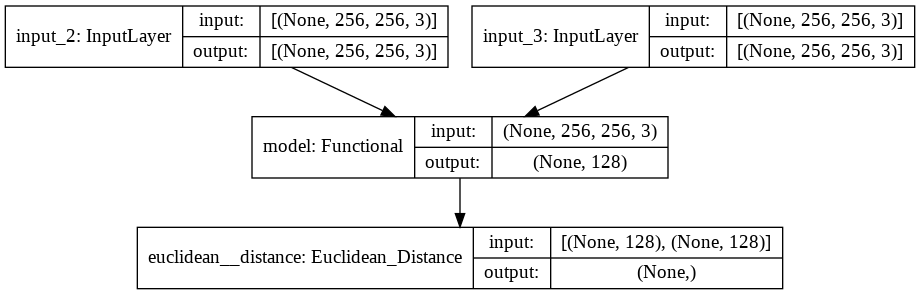

In [ ]:
model.load_weights('/content/drive/My Drive/pretrained/weights')
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
def loss(y_true,y_pred):
  margin = 1
  similarity = y_true * tf.square(y_pred) 
  dissimilarity = (1 - y_true) * tf.square(tf.maximum((margin - y_pred), 0)) 
  return tf.reduce_mean(dissimilarity + similarity) / 2

In [ ]:
anchor_class = 0

In [ ]:
epochs = 10
batch_size = 32 
factor = 64
#validation_fraction = 0.1
dataset_size = 72 * factor
steps_per_epoch = dataset_size // batch_size
#validation_steps = (validation_fraction * dataset_size) // batch_size

model.compile(loss = loss, optimizer= tf.keras.optimizers.Adam(9e-6))

In [ ]:
train_input = batch_images(dataset_size = dataset_size)
train_gen = ImageDataGenerator(brightness_range = (0.4,1.8),zca_whitening=True,horizontal_flip = True)
train_generator = train_gen.flow(x = train_input[0], y = train_input[1], batch_size = batch_size)

In [ ]:
r = model.fit(train_generator,batch_size = batch_size,steps_per_epoch = steps_per_epoch ,epochs= epochs)

Epoch 1/10
144/144 [==============================] - 48s 247ms/step - loss: 80.7532
Epoch 2/10
144/144 [==============================] - 36s 250ms/step - loss: 38.0426
Epoch 3/10
144/144 [==============================] - 37s 253ms/step - loss: 27.0459
Epoch 4/10
144/144 [==============================] - 37s 256ms/step - loss: 21.9345
Epoch 5/10
144/144 [==============================] - 37s 258ms/step - loss: 19.3177
Epoch 6/10
144/144 [==============================] - 37s 260ms/step - loss: 17.3892
Epoch 7/10
144/144 [==============================] - 38s 261ms/step - loss: 15.6683
Epoch 8/10
144/144 [==============================] - 38s 262ms/step - loss: 14.2783
Epoch 9/10
144/144 [==============================] - 38s 263ms/step - loss: 13.4132
Epoch 10/10
144/144 [==============================] - 38s 263ms/step - loss: 12.1232


In [ ]:
model.save('/content/drive/My Drive/trainedModel')

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/trainedModel',compile = False)